In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import emcee
import arviz as az
from getdist import plots, MCSamples
import os

In [2]:
# Load data
data = np.loadtxt("LPV_Gaia_8.1_229_30.txt")
r_data, v_data, v_err = data[:, 0], data[:, 1], data[:, 2]

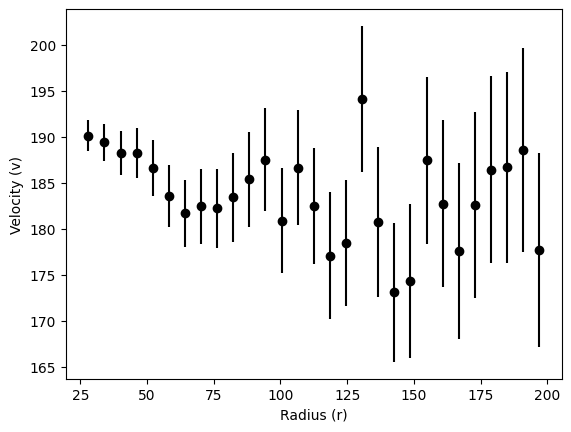

In [3]:
plt.errorbar(r_data, v_data, yerr=v_err, fmt="o", color="black", label="Data")
plt.xlabel("Radius (r)")
plt.ylabel("Velocity (v)")
#plt.xlim(0, 25)
#plt.title("Data with Error Bars")
plt.show()

In [4]:
# Constants
gravConst = 4.302e-6  # M_sun^-1 (km/s)^2 kpc
R_sun = 8.0  # kpc
GeVcm3_to_Msunkpc3 = 2.685e7  # GeV/cm^3 to M_sun/kpc^3
Msunpc2_to_Msunkpc2 = 1.0e6  # M_sun/pc^2 to M_sun/kpc^2

In [5]:
def v_NFW(Rho_sun, Rs, r):
    """NFW velocity profile."""
    Rhos = (Rho_sun * GeVcm3_to_Msunkpc3) * (R_sun / Rs) * (1 + (R_sun / Rs))**2
    gr = np.log(np.maximum((Rs + r) / Rs, 1e-10)) - (r / (Rs + r + 1e-10))
    mass = 4.0 * np.pi * Rhos * gr * Rs**3
    return np.sqrt(gravConst * mass / np.maximum(r, 1e-10))

def v_EXP(sigma_sun, Rb, r):
    """Thin exponential disc velocity profile."""
    Sigmab = (sigma_sun * Msunpc2_to_Msunkpc2) * np.exp(R_sun / Rb)
    mb = 2.0 * np.pi * Rb**2 * Sigmab
    y = r / (2.0 * Rb)
    vsq = 2.0 * gravConst * (mb / Rb) * (y**2) * (sp.i0(y) * sp.k0(y) - sp.i1(y) * sp.k1(y))
    if np.any(np.isnan(vsq)):  # Corrected line
        return 0.0  # Handle NaN values.
    if np.any(vsq < 0): # handles negative values in vsq.
        return 0.0
    return np.sqrt(np.abs(vsq))

def v_total(params, r):
    """Total velocity from both components."""
    rhoDM_sun, Rs, sigma_sun, Rb = params
    return np.sqrt(v_NFW(rhoDM_sun, Rs, r)**2 + v_EXP(sigma_sun, Rb, r)**2)

In [6]:
def log_likelihood(params, r, v_obs, v_err):
    """Log-likelihood function for MCMC."""
    v_model = v_total(params, r)
    return -0.5 * np.sum(((v_obs - v_model) / v_err) ** 2)

def log_prior(params):
    """Flat Prior distributions for parameters."""
    rhoDM_sun, Rs, sigma_sun, Rb = params
    if 0.1 < rhoDM_sun < 1 and 0.01 < Rs and 20 < sigma_sun < 100 and 0.5 < Rb < 15:
        return 0.0  # Uniform prior (log probability = 0)
    return -np.inf  # Log probability = -inf if out of bounds

# def log_prior(params):
#     """Gaussian prior distributions for parameters."""
#     rhoDM_sun, Rs, sigma_sun, Rb = params
#     gaussian_priors = [sigma_sun, Rb]
    
#     # Define means and standard deviations for your parameters using numpy arrays
#     means = np.array([48.0, 2.3])
#     stds = np.array([8.0, 0.6])

#     if  rhoDM_sun <=0.05 or rhoDM_sun >= 1.0 or Rs <= 0 or sigma_sun <= 0 or Rb <= 0:
#         return -np.inf
    
#     # Calculate log probabilities for each parameter
#     log_priors = -0.5 * ((np.array(gaussian_priors) - means) / stds)**2 - 0.5 * np.log(2 * np.pi * stds**2)

#     # Return the sum of the log probabilities
#     return np.sum(log_priors)

def log_probability(params, r, v_obs, v_err):
    """Total log-probability function for MCMC."""
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    #print(params[1])
    return lp + log_likelihood(params, r, v_obs, v_err)

In [7]:
# MCMC setup
ndim = 4  # Number of parameters
nwalkers = 200  # Number of walkers
nsteps = 1000000  # Number of MCMC steps
initial = np.array([0.3, 10, 48, 2.3])  # Initial parameter guesses
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

In [8]:
# Run MCMC

moves = [emcee.moves.DEMove()]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r_data, v_data, v_err), a = 2.5, moves=moves)
# Run the MCMC sampler
print("Running MCMC...")
sampler.run_mcmc(pos, nsteps, progress=True)

Running MCMC...


100%|██████████| 1000000/1000000 [4:18:05<00:00, 64.58it/s]   


State([[1.44551161e-01 6.18902973e+01 8.80292010e+01 8.67835379e+00]
 [1.11170079e-01 9.17979208e+01 9.88015332e+01 9.67844549e+00]
 [1.30216300e-01 7.62936937e+01 9.75735019e+01 8.26133368e+00]
 [1.55661288e-01 6.20221232e+01 8.28452098e+01 7.92056682e+00]
 [1.00168706e-01 1.02026836e+02 9.56346164e+01 1.09633324e+01]
 [1.16385365e-01 8.16137598e+01 9.87799354e+01 9.19863866e+00]
 [1.19694754e-01 8.03983288e+01 9.41388094e+01 9.31797704e+00]
 [1.31851708e-01 7.07483966e+01 8.67885633e+01 9.80097442e+00]
 [1.22805240e-01 7.85993104e+01 9.49551965e+01 9.39311873e+00]
 [1.21479552e-01 7.77707636e+01 8.75603411e+01 1.07018927e+01]
 [1.31569829e-01 7.28239290e+01 8.81635854e+01 9.44132153e+00]
 [1.38766934e-01 6.64193858e+01 9.20765224e+01 8.61534529e+00]
 [1.42355556e-01 6.59389497e+01 9.18405187e+01 8.40206585e+00]
 [1.11457984e-01 9.24450229e+01 9.97210869e+01 8.84257919e+00]
 [1.29180267e-01 7.68079874e+01 9.72174921e+01 8.36295682e+00]
 [1.55967677e-01 6.06979258e+01 8.59701781e+01 7.

In [9]:
# Calculation of the acceptance rate
acceptance_rate = np.mean(sampler.acceptance_fraction)
print(f"Acceptance rate: {acceptance_rate}")

Acceptance rate: 0.15683425


In [10]:
import h5py
# Define the output directory
output_directory = r"C:\Amogh\Research\TIFR Project\Mass Modelling\NFW_single_exp_analysis\Analysis_for_LPV\LPV_analysis_wideflat_priors"  # You can change this to your desired path

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Define the filename for the HDF5 file
filename = "mcmc_chains.h5"

# Construct the full path to the output file
filepath = os.path.join(output_directory, filename)

# Open the HDF5 file in write mode ('w')
with h5py.File(filepath, "w") as f:
    # Create a dataset to store the chains
    chains_dataset = f.create_dataset("chains", data=sampler.get_chain())

    # Get the log-probability values
    log_prob_values = sampler.get_log_prob()
    log_prob_dataset = f.create_dataset("log_prob", data=log_prob_values)

    # You can also save other relevant information as attributes
    f.attrs["nwalkers"] = nwalkers
    f.attrs["ndim"] = ndim
    f.attrs["nsteps"] = nsteps

print(f"\nMCMC chains and log-probabilities saved to: {filepath}")


MCMC chains and log-probabilities saved to: C:\Amogh\Research\TIFR Project\Mass Modelling\NFW_single_exp_analysis\Analysis_for_LPV\LPV_analysis_wideflat_priors\mcmc_chains.h5


In [ ]:
# Autocorrelation time estimation
autocorr = sampler.get_autocorr_time(tol=25)
print("Autocorrelation time:", autocorr)

In [11]:
# Thinning the chain
thinning_factor = int(np.max(autocorr)/2) # thin by half the maximum autocorrelation time.
if thinning_factor > 0:
    samples = sampler.get_chain(flat=True, thin=thinning_factor)
    print(f"Chain thinned by {thinning_factor}")
else:
    samples = sampler.get_chain(flat=True)
labels = ["rhoDM_sun (GeV/cc)", "R_s (kpc)", "sigma_sun (Msun/pc^2)", "R_b (kpc)"]    

NameError: name 'autocorr' is not defined

In [ ]:
burnin = int(0.3 * samples.shape[0])
samples_burned = samples[burnin:]
print(f"Burn-in removed: {burnin} samples")

Burn-in removed: 33240 samples


Gelman-Rubin R-hat Statistic:
<xarray.Dataset> Size: 48B
Dimensions:      (param_dim_0: 4)
Coordinates:
  * param_dim_0  (param_dim_0) int32 16B 0 1 2 3
Data variables:
    param        (param_dim_0) float64 32B 1.0 1.0 1.003 1.003


array([[<Axes: ylabel='param\n1'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='param\n2'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='param\n0', ylabel='param\n3'>,
        <Axes: xlabel='param\n1'>, <Axes: xlabel='param\n2'>]],
      dtype=object)

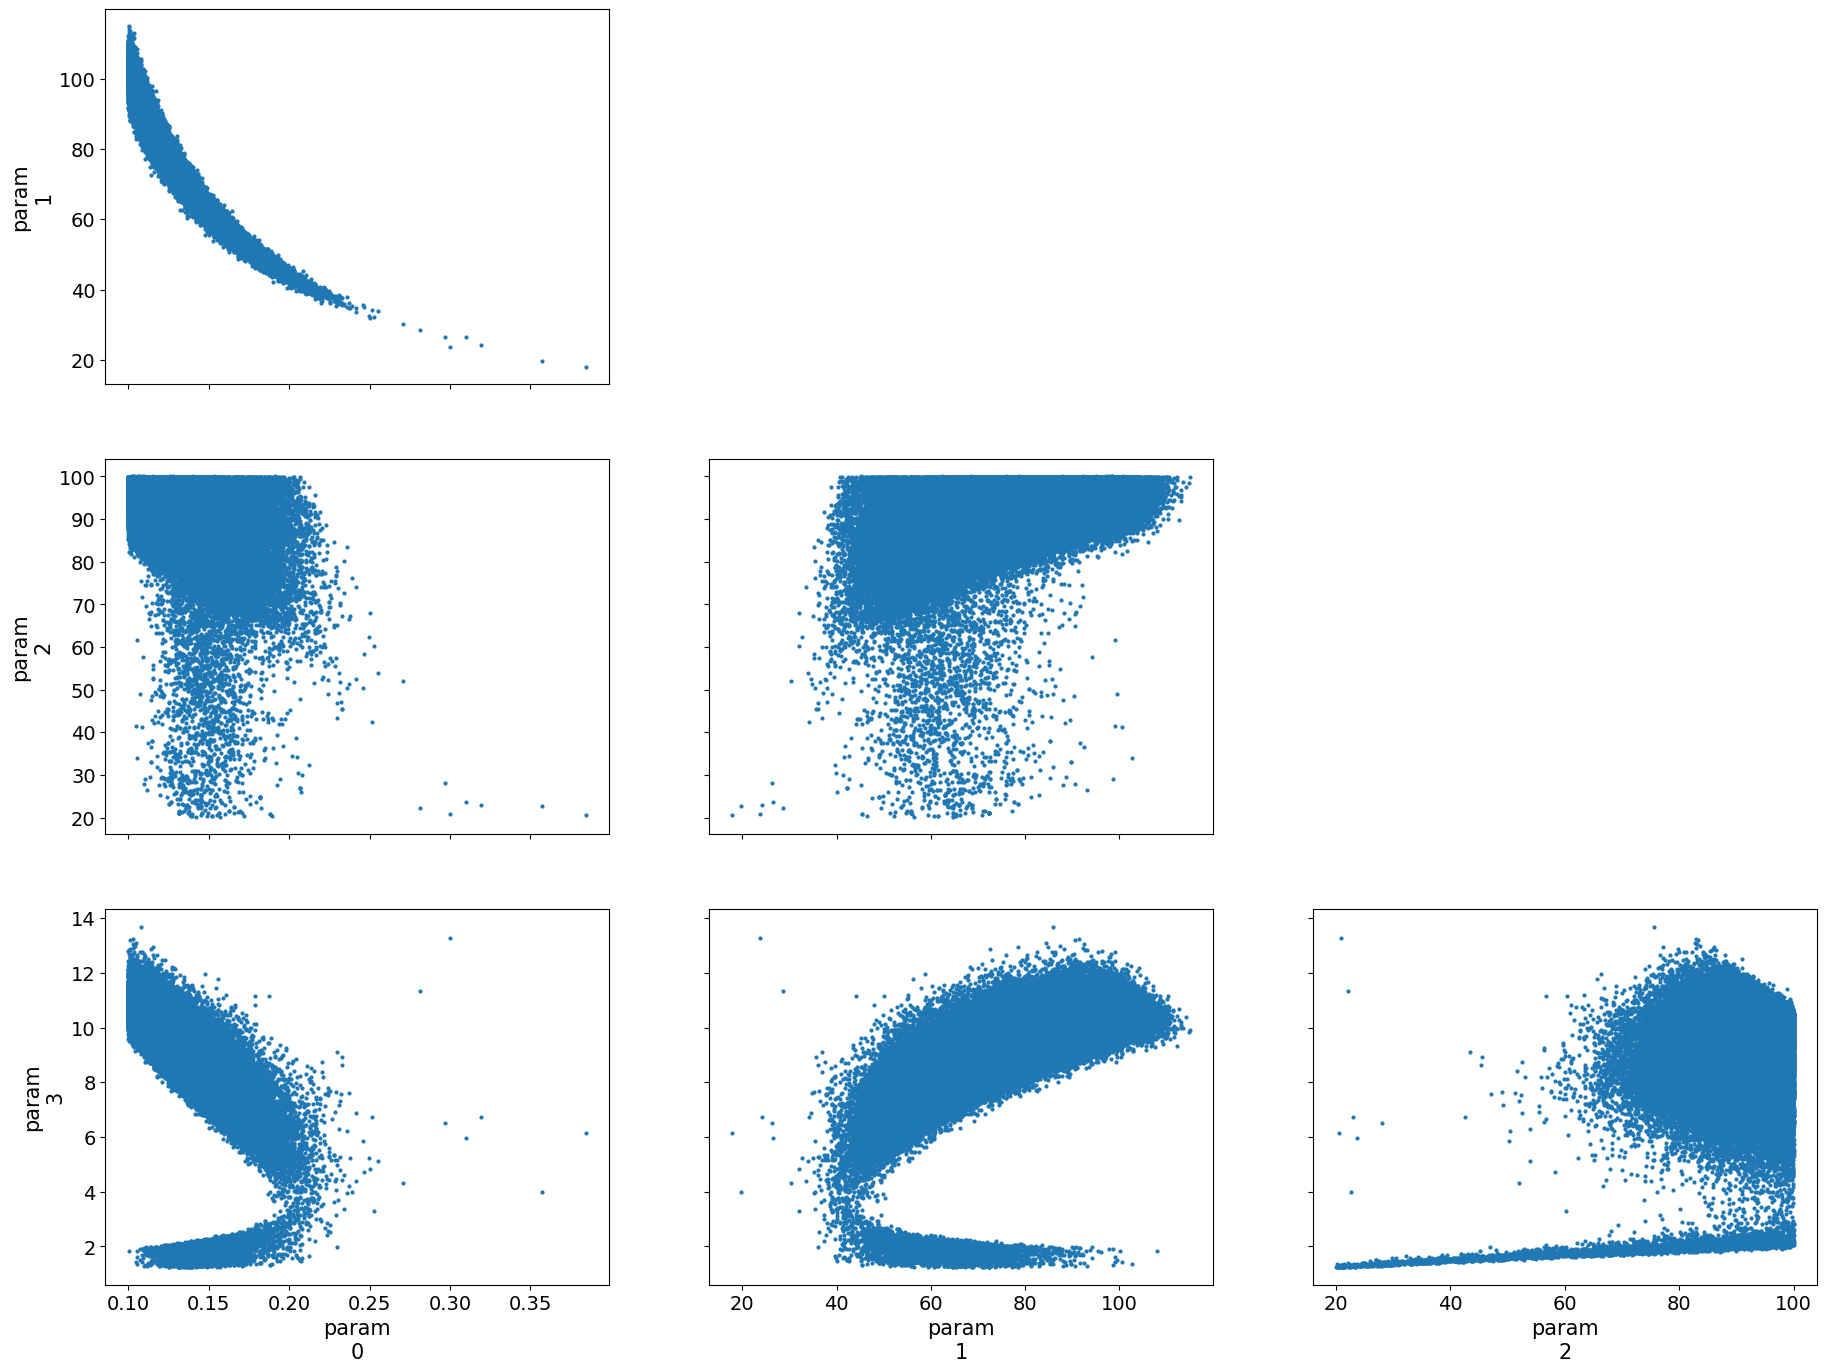

In [ ]:
samples1 = sampler.get_chain(thin=thinning_factor)  # Shape: (n_steps, n_walkers, n_parameters)

# Rearrange to (n_walkers, n_steps, n_parameters) for ArviZ
samples1 = np.transpose(samples1, (1, 0, 2))  # Shape: (n_walkers, n_steps, n_parameters)

# Convert to ArviZ InferenceData
az_data = az.from_dict(posterior={"param": samples1})

# Compute R-hat
r_hat = az.rhat(az_data)
print(f"Gelman-Rubin R-hat Statistic:\n{r_hat}")
az.plot_pair(az_data)

In [ ]:
# Additional improvements:
# 1. Adaptative moves:
# emcee has features that can help with convergence. Try using the a keyword in the EnsambleSampler.
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r_data, v_data, v_err), a=2.0)

# 2. Check the Gelman-Rubin statistic:
# This statistic can help determine if the chains have converged.

# 3. Increase walkers:
# If you have computational resources, increasing the number of walkers can help with convergence.

# 4. More steps:
# If the autocorrelation time is large, you may need to run the MCMC for more steps.

# 5. More informative priors:
# If you have prior knowledge about the parameters, you can use more informative priors.

# 6. Re-scale the data:
# If the data has a large range, re-scaling it can help with convergence.

# 7. Check for multi-modality:
# If the posterior distribution is multi-modal, you may need to use a different MCMC sampler.

Removed no burn in


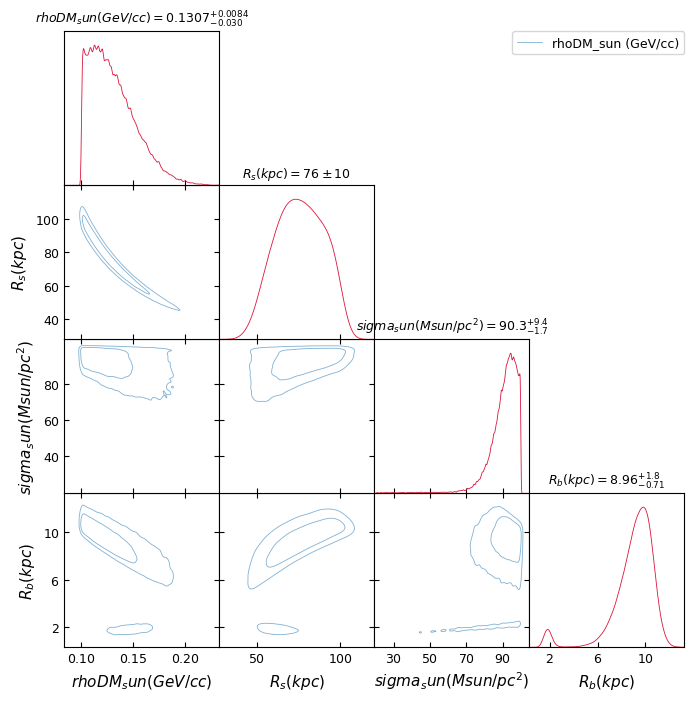

In [ ]:
mcsamples = MCSamples(samples=samples_burned, names=labels, labels=labels,
                      label='Eilers', settings={'contours': [0.68, 0.95], 'smooth_scale': 0.5, 'smooth_method': 'gaussian'})

# Create getdist plot
g = plots.get_subplot_plotter()
g.settings.axes_fontsize = 12  # Adjust font size as needed
g.settings.legend_fontsize = 12 # Adjust Legend font size as needed.
g.settings.scatter_size = 2
g.settings.solid_colors = ['royalblue']
g.settings.solid_contour_palefactor = 0.6

g.triangle_plot(mcsamples, vars=labels, filled_contours=True,
                contour_colors=['#80b1d3', '#377eb8'],
                line_args={'color': 'crimson'},  # Changed to crimson for truths
                title_limit=1,
                legend_labels=labels,
                legend_loc='upper right',
                truths=initial,
                truth_color='crimson')

plt.show()

In [ ]:
# Best-fit parameters
best_fit = np.median(samples_burned, axis=0)
print("Best-fit parameters:", best_fit)

Best-fit parameters: [ 0.1267658  76.03883937 92.14787651  9.33170863]


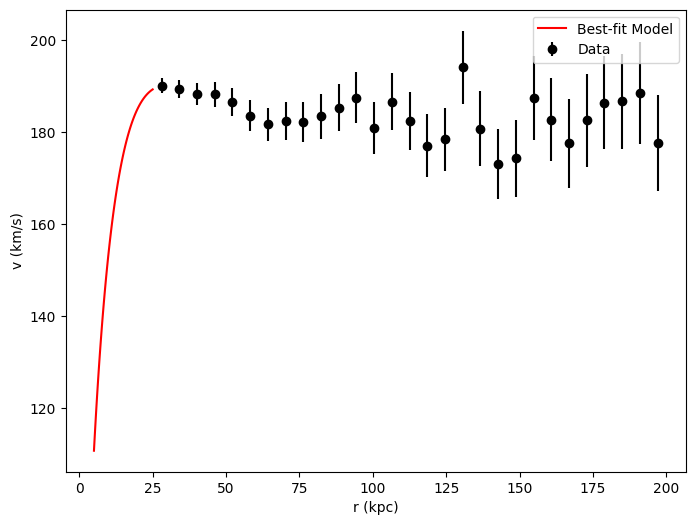

In [ ]:
# Plot rotation curve
r_fit = np.linspace(5, 25, 100)
v_fit = v_total(best_fit, r_fit)

plt.figure(figsize=(8, 6))
plt.errorbar(r_data, v_data, yerr=v_err, fmt="o", label="Data", color="black")
plt.plot(r_fit, v_fit, label="Best-fit Model", color="red")
plt.xlabel("r (kpc)")
plt.ylabel("v (km/s)")
plt.legend()
plt.show()

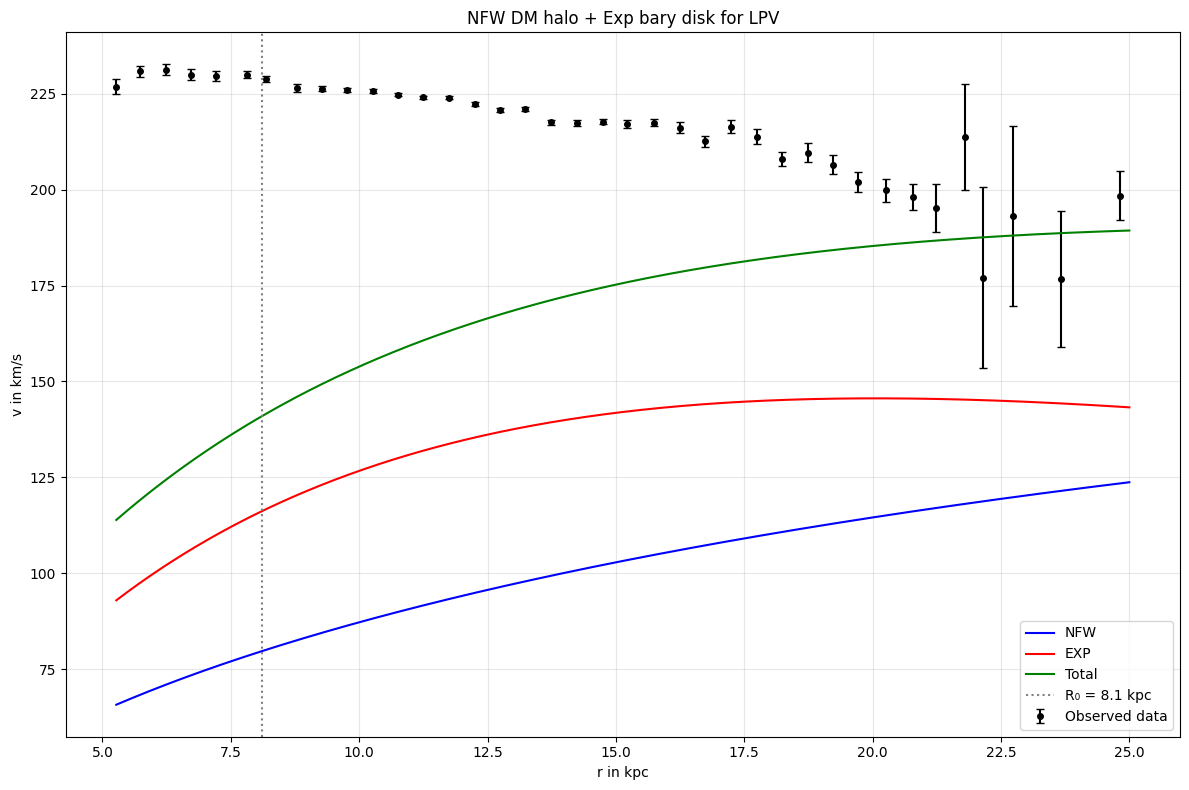

In [ ]:
# Load the data
data = np.loadtxt('Eilers_data.txt')  # Skip the header row

# Extract the columns
r_data = data[:, 0]  # Radius in kpc
v_data = data[:, 1]  # Velocity in km/s
v_err = data[:, 2]   # Velocity error in km/s

# Filter out rows with missing velocity data
valid_data = ~np.isnan(v_data)
r_data = r_data[valid_data]
v_data = v_data[valid_data]
v_err = v_err[valid_data]

# First, let's plot several model curves with different parameters
plt.figure(figsize=(12, 8))
plt.errorbar(r_data, v_data, yerr=v_err, fmt='o', color='black', 
             markersize=4, capsize=3, label='Observed data')

# These parameters seem to be from a previous fit
[Rho_sun, Rs, sigma_sun, Rb] = best_fit   
# [Rho_sun, Rs, sigma_sun, Rb] = [0.15046073,60.98004726,50.48576643,1.63244565]
              

r_model = np.linspace(np.min(r_data), 25, 1000)

# Calculate the model components directly
v_dark = v_NFW(Rho_sun, Rs, r_model)
v_bary = v_EXP(sigma_sun, Rb, r_model)
v_tot = np.sqrt(v_dark**2 + v_bary**2)

# For mock data generation (if needed)
v_err_mock = 0.05 * v_tot
v_noise = np.random.normal(0, v_err_mock)
v_final = v_tot + v_noise

# Plot everything
plt.plot(r_model, v_dark, c='b', label='NFW')
plt.plot(r_model, v_bary, c='r', label='EXP')
plt.plot(r_model, v_tot, c='g', label='Total')
#plt.errorbar(r_model, v_final, v_err_mock, c='g', fmt='.', capsize=2, elinewidth=0.5, label='mock RC data')

# Add the linear approximation
R0 = 8.1  # kpc
v0 = 229.0  # km/s
slope = -1.7  # km/s/kpc
v_linear = v0 + slope * (r_model - R0)

# Add to your plotting section
#plt.plot(r_model, v_linear, c='purple', linestyle='--', 
         #label=f'Linear model: v₀={v0}, slope={slope}')

# Add a vertical line at R0
plt.axvline(x=R0, color='gray', linestyle=':', label='R₀ = 8.1 kpc')

# Annotate key parameters on the plot
# plt.annotate(f'NFW: log₁₀ρₛ={logRhos:.2f}, Rₛ={Rs:.2f}', 
#              xy=(0.05, 0.95), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
# plt.annotate(f'EXP: log₁₀Σ={logSigmab:.2f}, Rb={Rb:.2f}', 
#              xy=(0.05, 0.90), xycoords='axes fraction',
#              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.legend()
plt.xlabel('r in kpc')
#plt.xlim(5, 25)
plt.ylabel('v in km/s')
plt.title('NFW DM halo + Exp bary disk for LPV')
plt.grid(True, alpha=0.3)
plt.tight_layout()